# Boosting
Do some hyperparameter optimization (note that I'm still tweaking feature engineering)
**See** hypteparameter plot at bottom

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
from scipy.stats import randint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

In [4]:
# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.model import load_and_process_training_data, feature_extraction  #, full_pipeline
from lib.model import param_grid, f1_scorer, kfold

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [6]:
full_pipeline = Pipeline(steps=[
                        ('features', feature_extraction),
                        ('imputer', Imputer(strategy='mean')),
                        ('feature_scaler', StandardScaler()),
                        ('xgb', XGBClassifier(random_state=1))])

In [7]:
X_train, y_train = load_and_process_training_data()

## Randomized search for RandomForest Parameters
(for now, I'm just gonna using max_depth = 30 and optimize elsewhere

In [8]:
# %%time

# param_dist = dict(xgb__max_depth=randint(14,40),
#                  xgb__n_estimators=[100,300,500,1000,1500,2000,5000],
#                  xgb__learning_rate=[0.01, 0.05, 0.10])

# random_search = RandomizedSearchCV(full_pipeline, param_dist, cv=kfold, scoring=f1_scorer, n_jobs=-1)
# random_search.fit(X_train, y_train)

# report(random_search.cv_results_)

## Grid Search

In [10]:
param_grid = dict(xgb__max_depth=[30],
                xgb__n_estimators=[100,300,500,1000,2000],
                 xgb__learning_rate=[0.01, 0.05, 0.10])
print(param_grid)

{'xgb__max_depth': [30], 'xgb__n_estimators': [100, 300, 500, 1000, 2000], 'xgb__learning_rate': [0.01, 0.05, 0.1]}


In [11]:
%%time
grid = GridSearchCV(full_pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

report(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.358 (std: 0.027)
Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 30, 'xgb__n_estimators': 500}

Model with rank: 2
Mean validation score: 0.356 (std: 0.031)
Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 30, 'xgb__n_estimators': 1000}

Model with rank: 3
Mean validation score: 0.355 (std: 0.028)
Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 30, 'xgb__n_estimators': 300}

Wall time: 39min 25s


In [12]:
%%time
grid = GridSearchCV(model, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

report(grid.cv_results_)

NameError: name 'model' is not defined

In [13]:
model = grid.best_estimator_
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('extract_rent', FeatureEngineer(func=<function feature_engineer_rent at 0x00000191E6FE0840>,
        level='low')), ('extract_educ', FeatureEngineer(func=<function feature_engineer_education at 0x00000191E6FE08C8>,
        level='l...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [14]:
%%time
plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

NameError: name 'plot_learning_curve' is not defined

In [15]:
results = pd.DataFrame({'n_estimators':grid.cv_results_['param_xgb__n_estimators'].tolist(), 'mean_test_score':grid.cv_results_['mean_test_score']}) 
             #columns = ['n_estimators', 'mean_train_score'])

In [16]:
results = pd.DataFrame({'n_estimators':grid.cv_results_['param_xgb__n_estimators'].tolist(),
                        'learning_rate':grid.cv_results_['param_xgb__learning_rate'].tolist(), 
                        'mean_test_score':grid.cv_results_['mean_test_score']}) 
             #columns = ['n_estimators', 'mean_train_score'])

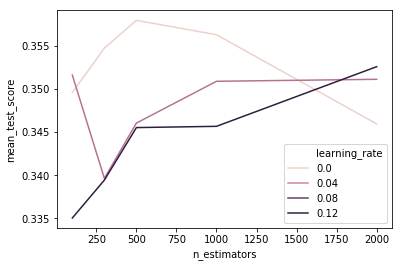

In [17]:
sns.lineplot(x='n_estimators', y='mean_test_score', hue='learning_rate', data=results)

## TODO 
- see if setting early_stopping_rounds gives you the same n_estimators as grid_search (requires holding out some test data as per https://www.kaggle.com/dansbecker/xgboost) 